# Homework 4

![](https://miro.medium.com/max/981/1*TPue9ee6I3iTNKz-clF4fA.png)

## Image Classification and Image Segmentation

In the task of image classification, we classify images based on their content. Each image is associated with a label indicating the category it belongs to.

Unlike image classification, image segmentation involves classifying each pixel in an image (background, cat, dog, person, etc.). Both image classification and image segmentation classify images, but there are some differences.

### Image Classification

Image classification involves classifying the entire image.

- **Input:** Image (bs, 3, h, w) (channel = 3 if RGB else 1)
- **Label:** Class (bs,)
- **Output:** Pred (bs, c) (c is the number of classification classes)

### Image Segmentation

Image segmentation classifies each pixel in an image.

- **Input:** Image (bs, 3, h, w) (c = 3 if RGB else 1)
- **Label:** Image (bs, h, w)
- **Output:** Image (bs, c, h, w) (c is the number of segmentation classes)

In image segmentation tasks, both the width and height of the output and label need to be the same as the original image (input).

![](https://miro.medium.com/max/1332/1*tL8lb7J158bWbXEmLenGtw.png)

### Example Scenario

In this example, the output corresponding to an image has a size of (1, 6, 12, 18). In the second dimension, it represents the likelihood of belonging to each category, which can be thought of as probabilities. Typically, we apply log_softmax to this dimension before calculating cross-entropy.

For instance, (b, 1, i, j) represents the likelihood at position (i, j) in the image of batch b belonging to label one (person). This likelihood indicates the probability of the image containing a person at that specific location.

In [ ]:
# For network processing
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import argparse

# For system operation
import os
import io
import random
import datetime
import time
import glob
from tqdm import tqdm

# For image processing
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# For data augmentation
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import *

# For data processing
import wandb
from collections import defaultdict, deque

!pip install -q torchprofile
from torchprofile import profile_macs

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
api_token = {"username":"xx","key":"xx"}
import json
import zipfile

if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')
!kaggle competitions download -c mia-hw-4 --force
!ls /kaggle

 99% 96.0M/96.8M [00:05<00:00, 23.4MB/s]
100% 96.8M/96.8M [00:05<00:00, 19.4MB/s]
input  mia-hw-4.zip


In [ ]:
!unzip \*.zip

## Utils

In [ ]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)

    # Set NumPy random seed
    np.random.seed(seed)

    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def print_with_timestamp():
    """
    This function add timestamp to each log info
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        timestamp = datetime.datetime.now().strftime("[%H:%M:%S]")
        args = (f"{timestamp} ",) + args
        builtin_print(*args, **kwargs)

    __builtin__.print = print

### Run Length Encoding

Run-Length Encoding (RLE) is a simple and efficient method for representing segmented masks in computer vision and image processing. In the context of image segmentation, RLE is often used to compress and store binary masks, where each pixel is either part of the segmented object (foreground) or not (background).

In [ ]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
        fg_val: Value representing the foreground in the input array (default is 1)
    Returns: run length encoding as list
    """
    # Find indices where the array is equal to the foreground value
    dots = np.where(x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right

    run_lengths = []
    prev = -2
    for b in dots:
        # If the index is not consecutive, start a new run
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1  # Increment the length of the current run
        prev = b

    return run_lengths

def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x:  # Check if the list is non-empty
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

def rle_decode(mask_rle, shape=(566, 640)):
    '''
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    # Initialize an array of zeros with the specified shape
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    # Check if the mask_rle is empty
    if mask_rle != '-':
        s = mask_rle.split()
        # Extract start and length information from the string
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1  # Convert to 0-based indexing
        ends = starts + lengths

        # Set the corresponding indices to 1 in the array
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1

    # Reshape the array to the specified shape and return
    return img.reshape(shape, order='F')  # Needed to align to RLE direction


In [ ]:
class WandbLogger(object):

    def __init__(self, config):

        self.config = config
        self._wandb =  wandb

    def login(self, key):
        self._wandb.login(key=key, relogin=True)

    def init_run(self):
        self.mask_table = wandb.Table(columns=["Images", "Masks", "Probs", "Preds", "Fusion", "IoU"], allow_mixed_types=True)
        self._wandb.init(
            config=self.config,
            project=self.config["project"],
            entity=self.config["entity"],
            name=self.config["name"],
            reinit=True
        )

    def log_checkpoints(self):
        output_dir = self.config["output_dir"]
        model_artifact = self._wandb.Artifact(
            self._wandb.run.id + "_model", type="model"
        )

        model_artifact.add_dir(output_dir)
        self._wandb.log_artifact(model_artifact, aliases=["latest", "best"])

    def log_image(self, images, masks, probs, binary_mask_threshold, fusion, iou):
        self.mask_table.add_data(
            wandb.Image(images),
            wandb.Image(masks),
            wandb.Image(probs),
            wandb.Image(binary_mask_threshold),
            wandb.Image(fusion),
            iou
        )

In [ ]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{value:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

In [ ]:
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {}'.format(header, total_time_str))

## Dataset

Classification augmentation is a technique used to artificially increase the diversity of a training dataset for image classification tasks. It involves applying various transformations to the input images while preserving their class labels. The goal is to enhance the model's ability to generalize to different variations of the input data.

Key Characteristics:

- **Input:** Single image with a corresponding class label.
- **Objective:** Enhance the model's ability to classify images by introducing variations.
- **Transformations:** Common transformations include random rotations, flips, changes in brightness, and shifts.

Segmentation augmentation is tailored for tasks where the goal is to predict pixel-wise labels for each image. Unlike classification augmentation, segmentation augmentation involves applying transformations to both the input images and their corresponding segmentation masks to maintain the spatial relationship between pixels and labels.

Key Characteristics:

- **Input:** Pair of images and segmentation masks.
- **Objective:** Improve the segmentation model's ability to handle variations in input images and maintain accurate pixel-wise predictions.
- **Transformations:** Similar to classification augmentation, but applied to both images and masks. This includes random flips, rotations, and changes in brightness.


In [ ]:
#TO DO: try to selecct a reasonable augmentation set!!
def build_transform(is_train, args):
    """
    Create a data transformation pipeline for image processing in deep learning tasks.
    """
    t = []
    if is_train:
        t.append(A.Resize(args.input_size[-2], args.input_size[-1]))
        t.append(A.Normalize(args.mean, args.std))
        t.append(ToTensorV2())
        return A.Compose(t)

    t.append(A.Resize(args.input_size[-2], args.input_size[-1]))
    t.append(A.Normalize(args.mean, args.std))
    t.append(ToTensorV2())
    return A.Compose(t)

In [ ]:
class DeepMedical(torch.utils.data.Dataset):
    def __init__(self, images, transforms = None):
        self.transforms = transforms

        self.image_paths = images
        self.mask_paths = [image.replace('pre', 'post') + '_ROI.bmp' for image in images]


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = np.array(Image.open(image_path).convert('RGB'))
        mask = np.array(Image.open(mask_path)) * 1

        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']

        return image, mask

class SonoDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

In [ ]:
class config:

    input_size = (8, 3, 448, 448)
    mean = IMAGENET_DEFAULT_MEAN
    std = IMAGENET_DEFAULT_STD

img_files = glob.glob("/kaggle/sono/train/pre/*")
ds = DeepMedical(images=img_files, transforms=build_transform(True, config))
dl = torch.utils.data.DataLoader(ds,batch_size=16,shuffle=False,num_workers=0)

plt.figure(figsize=(16,16))
imgs,masks = next(iter(dl))

for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*torch.tensor(config.std) + torch.tensor(config.mean))*255.0).numpy().astype(np.uint8)

    plt.subplot(4,4,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

print(f"Image shape: {imgs.shape}, mask shape {mask.shape}")

del ds,dl,imgs,masks

## Model

You can only use the concepts of UNet and FCN to construct a model.

- Find latest DL model here => [paper-with-code](https://paperswithcode.com/sota/semantic-segmentation-on-ade20k)

### Segmentation model evolution


- Reference => [Image segmentation](https://arxiv.org/pdf/2001.05566.pdf)

**Key Concepts**

1. Feature extractor

In segmentation models, feature extractor layers are used throughout the network, allowing it to process spatial information efficiently. These layers capture local patterns and structures in the input data.

2. Skip Connections

To recover fine-grained details lost during downsampling, FCN uses skip connections. These connections combine feature maps from early layers with those from later layers, aiding in the reconstruction of high-resolution information.

3. Upsampling

Segmentation models employ upsampling techniques to restore the spatial resolution of the feature maps. Transposed convolutions or bilinear interpolation can be used for this purpose.


#### FCN

- Paper => [FCN](https://arxiv.org/pdf/1411.4038.pdf)


#### U-net

- Paper => [Unet](https://arxiv.org/pdf/1505.04597.pdf)

#### ResUnet

- Paper => [ResUnet](https://arxiv.org/pdf/1711.10684.pdf)


#### ResUnet++

- Paper => [ResUnet++](https://arxiv.org/pdf/1911.07067.pdf)

**FCN-8**

In [ ]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()

        self.block1_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.block1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.block1_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block2_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.block2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.block2_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block3_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.block3_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.block3_conv3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.block3_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block4_conv1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.block4_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block4_conv3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block4_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block5_conv1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block5_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block5_conv3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block5_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block5_predict = nn.Conv2d(512, 2, kernel_size=1, padding=0)
        self.block5_up = nn.ConvTranspose2d(2, 2, kernel_size=4, stride=4, bias=False)  #2*unsampling

        self.block4_predict = nn.Conv2d(512, 2, kernel_size=1, padding=0)         #pool4 prediction
        self.block4_up = nn.ConvTranspose2d(2, 2, kernel_size=2, stride=2, bias=False)  #2*unsampling

        self.block3_predict = nn.Conv2d(256, 2, kernel_size=1, padding=0)  #pool3 pred

        self.total_upsample = nn.ConvTranspose2d(2, 2, kernel_size=8, stride=8, bias=False) #8倍unsampling

    def forward(self, x):
        block1 = self.block1_pool(self.block1_conv2(self.block1_conv1(x)))
        block2 = self.block2_pool(self.block2_conv2(self.block2_conv1(block1)))
        block3 = self.block3_pool(self.block3_conv3(self.block3_conv2(self.block3_conv1(block2))))
        block4 = self.block4_pool(self.block4_conv3(self.block4_conv2(self.block4_conv1(block3))))
        block5 = self.block5_pool(self.block5_conv3(self.block5_conv2(self.block5_conv1(block4))))

        transpose5 = self.block5_up(self.block5_predict(block5))
        transpose4 = self.block4_up(self.block4_predict(block4))
        transpose3 = self.block3_predict(block3)

        addition_upsample = transpose5+transpose4+transpose3
        output = self.total_upsample(addition_upsample)

        return output

**Unet**

In [ ]:
class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        #Repeated two 3*3 convolutions(unpadded)
        self.block1_conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.block1_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        # 定義 2x2 最大池化
        self.block1_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 定義 ReLU 激活函數
        self.relu = nn.ReLU()

        self.block2_conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.block2_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.block2_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block3_conv1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.block3_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.block3_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block4_conv1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.block4_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block4_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.block5_conv1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.block5_conv2 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.block5_up = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, bias=False)

        self.block45_conv1 = nn.Conv2d(512+512, 512, kernel_size=3, padding=1)
        self.block45_conv2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.block45_up = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, bias=False)

        self.block34_conv1 = nn.Conv2d(256+256, 256, kernel_size=3, padding=1)
        self.block34_conv2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.block34_up = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, bias=False)

        self.block23_conv1 = nn.Conv2d(128+128, 128, kernel_size=3, padding=1)
        self.block23_conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.block23_up = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, bias=False)

        self.block12_conv1 = nn.Conv2d(64+64, 64, kernel_size=3, padding=1)
        self.block12_conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.final_conv  = nn.Conv2d(64, 2, kernel_size=1)
    def forward(self, x):
        block1_temp = self.relu(self.block1_conv2(self.relu(self.block1_conv1(x))))  ##copy and crop
        block1 = self.block1_pool(block1_temp)
        block2_temp = self.relu(self.block2_conv2(self.relu(self.block2_conv1(block1))))  ##copy and crop
        block2 = self.block2_pool(block2_temp)
        block3_temp = self.relu(self.block3_conv2(self.relu(self.block3_conv1(block2))))  ##copy and crop
        block3 = self.block3_pool(block3_temp)
        block4_temp = self.relu(self.block4_conv2(self.relu(self.block4_conv1(block3))))  ##copy and crop
        block4 = self.block4_pool(block4_temp)
        block5 = self.block5_up(self.relu(self.block5_conv2(self.relu(self.block5_conv1(block4)))))

        block45_crop = torch.cat([block4_temp, block5], dim=1)
        block45 = self.block45_up(self.relu(self.block45_conv2(self.relu(self.block45_conv1(block45_crop)))))

        block34_crop = torch.cat([block3_temp, block45], dim=1)
        block34 = self.block34_up(self.relu(self.block34_conv2(self.relu(self.block34_conv1(block34_crop)))))

        block23_crop = torch.cat([block2_temp, block34], dim=1)
        block23 = self.block23_up(self.relu(self.block23_conv2(self.relu(self.block23_conv1(block23_crop)))))

        block12_crop = torch.cat([block1_temp, block23], dim=1)
        block12 = self.relu(self.block12_conv2(self.relu(self.block12_conv1(block12_crop))))

        output = self.final_conv(block12)

        return output

**ResUnet**

In [ ]:
class ResUnet(nn.Module):
    def __init__(self):
        super(ResUnet, self).__init__()

        self.input_layer = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1)
        )

        self.residual_conv_1 = ResidualConv(64, 128, 2, 1)
        self.residual_conv_2 = ResidualConv(128, 256, 2, 1)

        self.bridge = ResidualConv(256, 512, 2, 1)

        self.upsample_1 = Upsample(512, 512, 2, 2)
        self.up_residual_conv1 = ResidualConv(512 + 256, 256, 1, 1)

        self.upsample_2 = Upsample(256, 256, 2, 2)
        self.up_residual_conv2 = ResidualConv(256 + 128, 128, 1, 1)

        self.upsample_3 = Upsample(128, 128, 2, 2)
        self.up_residual_conv3 = ResidualConv(128 + 64, 64, 1, 1)

        self.output_layer = nn.Sequential(
            nn.Conv2d(64, 2, 1, 1),
            #nn.Conv2d(64, 1, 1, 1),
            #nn.Sigmoid(),
        )

    def forward(self, x):
        # Encode
        x1 = self.input_layer(x) + self.input_skip(x)
        x2 = self.residual_conv_1(x1)
        x3 = self.residual_conv_2(x2)
        # Bridge
        x4 = self.bridge(x3)
        # Decode
        x4 = self.upsample_1(x4)
        x5 = torch.cat([x4, x3], dim=1)

        x6 = self.up_residual_conv1(x5)

        x6 = self.upsample_2(x6)
        x7 = torch.cat([x6, x2], dim=1)

        x8 = self.up_residual_conv2(x7)

        x8 = self.upsample_3(x8)
        x9 = torch.cat([x8, x1], dim=1)

        x10 = self.up_residual_conv3(x9)

        output = self.output_layer(x10)

        output1 = output[:, :, :x.size(2), :x.size(3)]

        return output1


class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):
        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)

**ResUnet++**

https://github.com/rishikksh20/ResUnet/blob/master/core/res_unet_plus.py

In [ ]:
class ResUnetPlusPlus(nn.Module):
    def __init__(self):
        super(ResUnetPlusPlus, self).__init__()
        filters=[32, 64, 128, 256, 512]
        channel = 3
        self.input_layer = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.Conv2d(filters[0], filters[0], kernel_size=3, padding=1),
        )
        self.input_skip = nn.Sequential(
            nn.Conv2d(channel, filters[0], kernel_size=3, padding=1)
        )

        self.squeeze_excite1 = Squeeze_Excite_Block(filters[0])

        self.residual_conv1 = ResidualConv(filters[0], filters[1], 2, 1)

        self.squeeze_excite2 = Squeeze_Excite_Block(filters[1])

        self.residual_conv2 = ResidualConv(filters[1], filters[2], 2, 1)

        self.squeeze_excite3 = Squeeze_Excite_Block(filters[2])

        self.residual_conv3 = ResidualConv(filters[2], filters[3], 2, 1)

        self.aspp_bridge = ASPP(filters[3], filters[4])

        self.attn1 = AttentionBlock(filters[2], filters[4], filters[4])
        self.upsample1 = Upsample_(2)
        self.up_residual_conv1 = ResidualConv(filters[4] + filters[2], filters[3], 1, 1)

        self.attn2 = AttentionBlock(filters[1], filters[3], filters[3])
        self.upsample2 = Upsample_(2)
        self.up_residual_conv2 = ResidualConv(filters[3] + filters[1], filters[2], 1, 1)

        self.attn3 = AttentionBlock(filters[0], filters[2], filters[2])
        self.upsample3 = Upsample_(2)
        self.up_residual_conv3 = ResidualConv(filters[2] + filters[0], filters[1], 1, 1)

        self.aspp_out = ASPP(filters[1], filters[0])

        self.output_layer = nn.Sequential(nn.Conv2d(filters[0], 2, 1, 1),

                   )

    def forward(self, x):
        x1 = self.input_layer(x) + self.input_skip(x)

        x2 = self.squeeze_excite1(x1)
        x2 = self.residual_conv1(x2)

        x3 = self.squeeze_excite2(x2)
        x3 = self.residual_conv2(x3)

        x4 = self.squeeze_excite3(x3)
        x4 = self.residual_conv3(x4)

        x5 = self.aspp_bridge(x4)

        x6 = self.attn1(x3, x5)
        x6 = self.upsample1(x6)
        x6 = torch.cat([x6, x3], dim=1)
        x6 = self.up_residual_conv1(x6)

        x7 = self.attn2(x2, x6)
        x7 = self.upsample2(x7)
        x7 = torch.cat([x7, x2], dim=1)
        x7 = self.up_residual_conv2(x7)

        x8 = self.attn3(x1, x7)
        x8 = self.upsample3(x8)
        x8 = torch.cat([x8, x1], dim=1)
        x8 = self.up_residual_conv3(x8)

        x9 = self.aspp_out(x8)
        out = self.output_layer(x9)

        return out

class ResidualConv(nn.Module):
    def __init__(self, input_dim, output_dim, stride, padding):
        super(ResidualConv, self).__init__()

        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(input_dim),
            nn.ReLU(),
            nn.Conv2d(
                input_dim, output_dim, kernel_size=3, stride=stride, padding=padding
            ),
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, output_dim, kernel_size=3, padding=1),
        )
        self.conv_skip = nn.Sequential(
            nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(output_dim),
        )

    def forward(self, x):

        return self.conv_block(x) + self.conv_skip(x)


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class Squeeze_Excite_Block(nn.Module):
    def __init__(self, channel, reduction=16):
        super(Squeeze_Excite_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ASPP(nn.Module):
    def __init__(self, in_dims, out_dims, rate=[6, 12, 18]):
        super(ASPP, self).__init__()

        self.aspp_block1 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[0], dilation=rate[0]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block2 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[1], dilation=rate[1]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block3 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[2], dilation=rate[2]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )

        self.output = nn.Conv2d(len(rate) * out_dims, out_dims, 1)
        self._init_weights()

    def forward(self, x):
        x1 = self.aspp_block1(x)
        x2 = self.aspp_block2(x)
        x3 = self.aspp_block3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        return self.output(out)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class Upsample_(nn.Module):
    def __init__(self, scale=2):
        super(Upsample_, self).__init__()

        self.upsample = nn.Upsample(mode="bilinear", scale_factor=scale)

    def forward(self, x):
        return self.upsample(x)


class AttentionBlock(nn.Module):
    def __init__(self, input_encoder, input_decoder, output_dim):
        super(AttentionBlock, self).__init__()

        self.conv_encoder = nn.Sequential(
            nn.BatchNorm2d(input_encoder),
            nn.ReLU(),
            nn.Conv2d(input_encoder, output_dim, 3, padding=1),
            nn.MaxPool2d(2, 2),
        )

        self.conv_decoder = nn.Sequential(
            nn.BatchNorm2d(input_decoder),
            nn.ReLU(),
            nn.Conv2d(input_decoder, output_dim, 3, padding=1),
        )

        self.conv_attn = nn.Sequential(
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, 1, 1),
        )

    def forward(self, x1, x2):
        out = self.conv_encoder(x1) + self.conv_decoder(x2)
        out = self.conv_attn(out)
        return out * x2

## Metrics

Two commonly used metrics to evaluate the performance of segmentation algorithms are Dice Coefficient and Intersection over Union (IoU).

### Dice Coefficient

The Dice Coefficient, also known as the F1 Score, is a measure of the similarity between two sets. In the context of image segmentation, it is used to quantify the agreement between the predicted segmentation and the ground truth.

The formula for Dice Coefficient is given by:

$$ Dice = \frac{2 \times |X \cap Y|}{|X| + |Y|} $$

where:
- $X$ is the set of pixels in the predicted segmentation,
- $Y$ is the set of pixels in the ground truth,
- $|\cdot|$ denotes the cardinality of a set (i.e., the number of elements).

Dice Coefficient ranges from 0 to 1, where 1 indicates a perfect overlap between the predicted and ground truth segmentations.

### Intersection over Union (IoU)

IoU, also known as the Jaccard Index, is another widely used metric for segmentation evaluation. It measures the ratio of the intersection area to the union area between the predicted and ground truth segmentations.

The formula for IoU is given by:

$$
IoU = \frac{|X \cap Y|}{|X \cup Y|}
$$

where:
- $X$ is the set of pixels in the predicted segmentation,
- $Y$ is the set of pixels in the ground truth.

Similar to Dice Coefficient, IoU ranges from 0 to 1, with 1 indicating a perfect overlap.

![](https://www.mathworks.com/help/vision/ref/jaccard.png)

### Interpretation

- **High Values**: A higher Dice Coefficient or IoU indicates better segmentation performance, as it signifies a greater overlap between the predicted and ground truth regions.

- **Low Values**: Lower values suggest poor segmentation accuracy, indicating a mismatch between the predicted and ground truth segmentations.

### Implementation

Dice coefficient and IoU can be calculated by confusion matrix. Therefore, the initial step is to build an confusion matrix from scratch.

**Algorithm: Building Confusion Matrix $M$**

**Input:**
- a: Target labels tensor
- b: Predicted labels tensor
- num_classes: Number of classes

**Procedure:**
1. Initialize the confusion matrix (self.mat) if it is not already created:
   - Create a square matrix of zeros with shape (num_classes, num_classes) and dtype=torch.int64.
   - Place the matrix on the same device as the input tensor `a`.

2. Update the confusion matrix using the update method:

   a. Check for valid class indices:
      - Create a boolean mask k, where elements are True if a is in the range [0, num_classes) and False otherwise.
      
   b. Calculate indices for updating the confusion matrix:
      - Convert the valid elements of `a` and `b` to torch.int64 and calculate the indices using the formula n * a[k] + b[k], where n is the number of classes.
         - **We represent class-i pixels classify to class-j as $\to n * i + j$**
      - Increment the corresponding elements in the confusion matrix using torch.bincount.

3. Compute segmentation metrics using the compute method:
   - Convert the confusion matrix to a float tensor h.
   - Extract correct predictions along the diagonal of the matrix.
   - Compute metrics from $M$
      - `acc` $\to M_{ii}/M_{i\cdot}$
      - `global_acc` $\to sum(M_{ii})/M_{\cdot\cdot}$
      - `dice` $\to \frac{2M_{ii}}{M_{i\cdot}+M_{\cdot i}}$
      - `iou` $\to \frac{M_{ii}}{M_{i\cdot}+M_{\cdot i}-M_{ii}}$

**Output:**
- The confusion matrix is updated and segmentation metrics are computed.
- The $(i, j)-$terms of the $M$ represents class-i pixels classify to class-j

Note: In practice, we often omit the metrics from the background!!

In [ ]:
class ConfusionMatrix(object):
    """
    update: use to update the confusion matrix in sample-wise
        a: ground truths
        b: predictions

    The (i, j) terms of the matrix represents class-i pixels classify to class-j
    """
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, a, b):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=a.device)
        with torch.no_grad():
            k = (a >= 0) & (a < n)
            inds = n * a[k].to(torch.int64) + b[k]
            self.mat += torch.bincount(inds, minlength=n**2).reshape(n, n)

    def reset(self):
        if self.mat is not None:
            self.mat.zero_()

    def compute(self):
        h = self.mat.float()
        correct = torch.diag(h)
        acc_global = correct.sum() / h.sum()
        acc = correct / h.sum(1)
        dice = 2 * correct  / (h.sum(1) + h.sum(0))
        iou = correct / (h.sum(1) + h.sum(0) - correct)

        self.acc_global = acc_global
        self.acc = acc
        self.iou = iou
        self.dice = dice

        return acc_global, acc, iou, dice

    def reduce_from_all_processes(self):
        if not torch.distributed.is_available():
            return
        if not torch.distributed.is_initialized():
            return
        torch.distributed.barrier()
        torch.distributed.all_reduce(self.mat)

    def __str__(self):
        acc_global, acc, iou, dice = self.compute()
        self.acc_global = acc_global
        self.miou = iou.mean().item() * 100
        self.dice = dice.mean().item() * 100
        return (
            'global correct: {:.2f}\n'
            'average row correct: {}\n'
            'IoU: {} mean IoU: {:.2f}\n'
            'dice: {} mean Dice: {:.2f}\n').format(
                acc_global.item() * 100,
                ['{:.1f}'.format(i) for i in (acc * 100).tolist()],
                ['{:.1f}'.format(i) for i in (iou * 100).tolist()],
                iou.mean().item() * 100,
                ['{:.2f}'.format(i) for i in (dice * 100).tolist()],
                dice.mean().item() * 100,
            )

class intersection_over_union:

    def __init__(self, y_true, y_pred):

        union = np.count_nonzero(y_true + y_pred)
        intersection = np.count_nonzero(y_true * y_pred)
        try:
            IoU = intersection / union
        except:
            IoU = 0
        self.IoU = IoU
        self.union = (y_true + y_pred != 0) * 1
        self.intersection = (y_true * y_pred != 0) * 1
        self.FP = (y_true == 0) * (y_pred == 1) * 1
        self.FN = (y_true == 1) * (y_pred == 0) * 1

def visualization(model, valid_loader, args):

    for images, masks in valid_loader:

        images = images.to(device=args.device, dtype=torch.float)
        masks = masks.to(device=args.device, dtype=torch.long)

        logits = model(images)
        probs = torch.nn.functional.softmax(logits, dim=1)

        probs = probs[:,1,:,:]
        preds = (probs.permute(1,2,0) * 255).cpu().detach().numpy().astype(np.uint8)

        threshold = 0.5

        binary_mask_threshold = (probs > threshold) * 1

        masks = (masks.permute(1,2,0) * 255).cpu().numpy().astype(np.uint8)
        images = ((images.squeeze(0).permute(1,2,0).cpu().detach().numpy()*np.array(args.std)+np.array(args.mean)) * 255).astype(np.uint8)
        probs = (probs.permute(1,2,0) * 255).cpu().detach().numpy().astype(np.uint8)
        binary_mask_threshold = (binary_mask_threshold.permute(1,2,0) * 255).cpu().detach().numpy().astype(np.uint8)

        iou = intersection_over_union(masks/255.0, binary_mask_threshold/255.0)
        IoU = iou.IoU
        intersection = iou.intersection
        union = iou.union
        FP = iou.FP
        FN = iou.FN

        fusion = np.concatenate([FP*255, intersection*255, FN*255], axis=2).astype(np.uint8)

        yield images, masks, probs, binary_mask_threshold, fusion, IoU

## Train/Eval

In [ ]:
def train_one_epoch(model, train_loader, criterion, device, epoch, optimizer, print_freq=10, num_classes=2):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    confmat = ConfusionMatrix(num_classes)
    for images, masks in metric_logger.log_every(train_loader, print_freq, header):
        images = images.to(device=device, dtype=torch.float)
        masks = masks.to(device=device, dtype=torch.long)

        logits = model(images)
        loss = criterion(logits, masks)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        confmat.update(masks.flatten(), logits.argmax(1).flatten())
        confmat.compute()

        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(mIoU=torch.mean(confmat.iou[1:]))
        metric_logger.update(Dice=torch.mean(confmat.dice[1:]))

    confmat.reduce_from_all_processes()

@torch.no_grad()
def evaluate(model, data_loader, criterion, device, print_freq=10, num_classes=2, header=None):
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = header

    confmat = ConfusionMatrix(num_classes)
    for images, masks in metric_logger.log_every(data_loader, print_freq, header):
        images = images.to(device=device, dtype=torch.float)
        masks = masks.to(device=device, dtype=torch.long)

        logits = model(images)
        loss = criterion(logits, masks)

        confmat.update(masks.flatten(), logits.argmax(1).flatten())
        confmat.compute()

        metric_logger.update(loss=loss.item())
        metric_logger.update(mIoU=torch.mean(confmat.iou[1:]))
        metric_logger.update(Dice=torch.mean(confmat.dice[1:]))

    confmat.reduce_from_all_processes()

    return metric_logger, confmat

In [ ]:
def plot_metrics(history, output_dir):
    import matplotlib.pyplot as plt

    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["valid_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()
    #plt.savefig(os.path.join(output_dir, "loss_curve.png"))
    plt.show()

    # mIoU
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history["train_miou"], label="Train mIoU", marker="o")
    plt.plot(epochs, history["valid_miou"], label="Validation mIoU", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("mIoU")
    plt.title("mIoU over Epochs")
    plt.legend()
    #plt.savefig(os.path.join(output_dir, "miou_curve.png"))
    plt.show()

    # Dice
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history["train_dice"], label="Train Dice", marker="o")
    plt.plot(epochs, history["valid_dice"], label="Validation Dice", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Dice")
    plt.title("Dice over Epochs")
    plt.legend()
    #plt.savefig(os.path.join(output_dir, "dice_curve.png"))
    plt.show()


## How to log metrics?

Available tools:

- TensorBoard
- W & B

Both Weights & Biases (WandB) and TensorBoard are tools commonly used in machine learning to visualize and monitor the training process of deep learning models. They provide insights into various aspects of the training and evaluation phases, helping researchers and practitioners analyze and improve model performance.

### WandB (Weights & Biases)

1. Overview:

Weights & Biases (WandB) is a machine learning experiment tracking and visualization platform.
It's designed to help researchers and data scientists log and analyze experiments, track model performance, and share results.

2. Key Features:

- Experiment Tracking: Log hyperparameters, metrics, and other experiment details Organize and compare experiments easily.
- Visualizations: Provides interactive charts and plots for metrics. Supports visualizing model architectures, confusion matrices, and more.
- Collaboration: Enables collaboration within teams by sharing experiment results. Supports integration with Git for version control.
- Integration: Integrates with popular deep learning frameworks like TensorFlow and PyTorch. Compatible with various languages, including Python and R.
- Artifacts: Allows tracking datasets, models, and other artifacts associated with experiments.
- Reproducibility: Aids in reproducing experiments with saved configurations and environment details.

3. Usage:

https://docs.wandb.ai/quickstart

##ResUnet++

https://github.com/rishikksh20/ResUnet/blob/master/core/res_unet_plus.py

In [ ]:
#TO DO: try to set a more fitness parameters
def get_args():
    parser = argparse.ArgumentParser(description='SonoDataset Training')
    parser.add_argument('--root', type=str, default="/kaggle/sono")
    parser.add_argument('--device', type=str, default="cuda" if torch.cuda.is_available() else "cpu")
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('--weight_decay', type=float, default=1e-7)
    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--lr', type=float, default=1e-3)
    parser.add_argument('--num_classes', type=int, default=2)
    parser.add_argument('--seed', type=int, default=42)

    parser.add_argument('--in_channels', type=int, default=3)
    parser.add_argument('--input_size', type=tuple, default=(4, 3, 224, 224))
    parser.add_argument('--target_size', type=tuple, default=(566, 640))
    parser.add_argument('--mean', type=list, default=IMAGENET_DEFAULT_MEAN)
    parser.add_argument('--std', type=list, default=IMAGENET_DEFAULT_STD)

    parser.add_argument('--project', type=str, default="MIA-HW4")
    parser.add_argument('--entity', type=str, default="DDCVLAB")
    parser.add_argument('--name', type=str, default="Unet")
    parser.add_argument('--wandb', type=bool, default=False)
    parser.add_argument('--sweep', type=bool, default=True)
    parser.add_argument('--sweep_counts', type=int, default=8)

    parser.add_argument('--output_dir', type=str, default="")
    parser.add_argument('--data_path', type=str, default="/kaggle/sono/train/pre/*")

    args, _ = parser.parse_known_args()
    return args

sweep_config = {
    "program": "main.py",
    "method": "random", # ["random", "grid", "bayes"]
    "metrics": {'goal': 'maximize', 'name': 'Validation Dice'},
    "parameters": {
        "lr": {
            "values": [1e-3, 5e-4, 1e-4, 5e-5]
        },
        "weight_decay": {
            "values": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
        },
    }
}

/usr/local/lib/python3.10/dist-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::expand_as". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


Training augmentation: Compose([
  Resize(p=1.0, height=224, width=224, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
number of params (M): 14482597.00
model flops (G): 108.279011008 input_size: (4, 3, 224, 224)
LR = 0.00100000
WD = 0.00000010
Batch size = 4
Number of training epochs = 10
Number of training examples = 240
Number of training steps per epoch = 60
Use Cosine LR scheduler
criterion = CrossEntropyLoss()
Start Training
Epoch: [0]  [ 0/60]  eta: 0:00:31  lr: 0.000040  loss: 0.8283 (0.8283)  mIoU: 0.1214 (0.1214)  Dice: 0.2165 (0.2165)  time: 0.5242  data: 0.0184  max mem: 2617
Epoch: [0]  [10/60]  eta: 0:00:26  lr: 0.000040  loss: 0.7360 (0.7586)  mIoU: 0.1697 (0.1587)  Dice: 0.2902 (0.2735)  time: 0.5212  data: 0.0160  max 

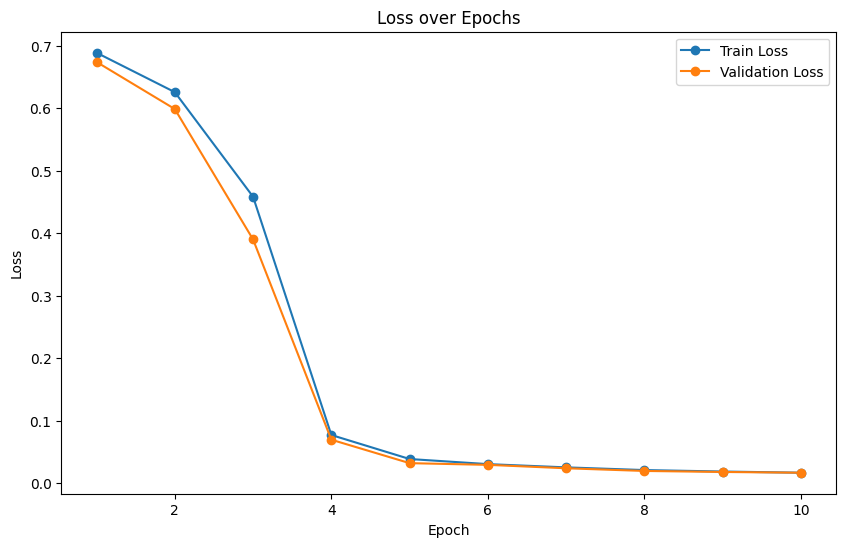

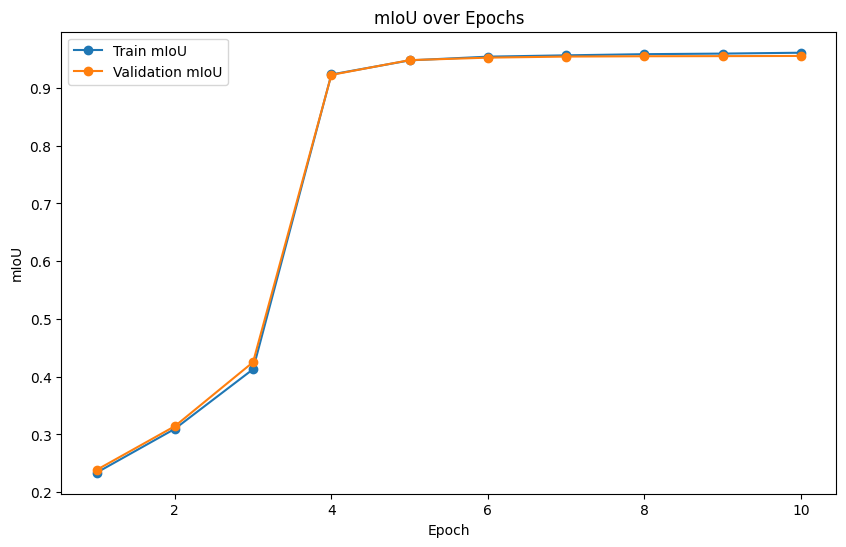

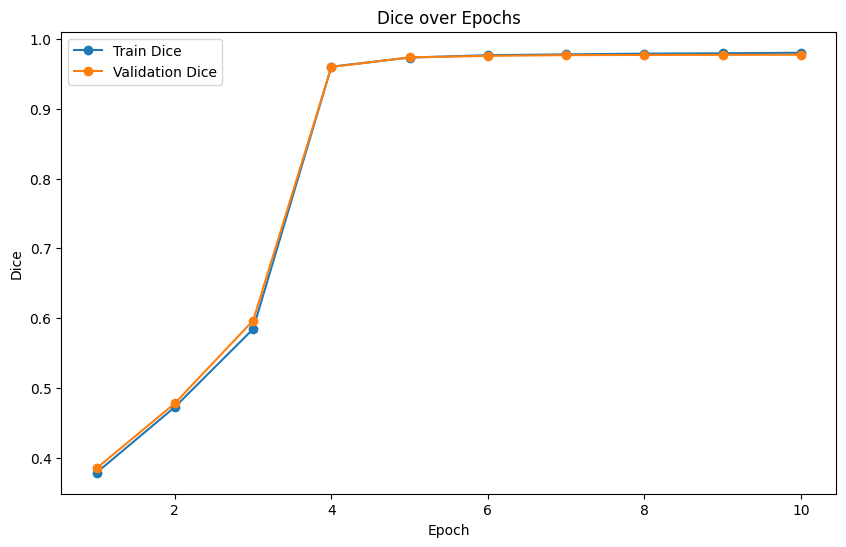

Finish


In [ ]:
def sweeper(wandb_logger, args):

    if wandb_logger:
        wandb_logger.init_run()
        args = wandb_logger._wandb.config

    seed_everything(args.seed)

    img_files = glob.glob(args.data_path)

    train_ids, valid_ids = train_test_split(range(len(img_files)), test_size=0.2, random_state=args.seed)
    train_transform, valid_transform = build_transform(True, args), build_transform(False, args)
    train_dataset = DeepMedical(images=img_files, transforms=train_transform)
    valid_dataset = DeepMedical(images=img_files, transforms=valid_transform)
    train_dataset = SonoDataset(train_dataset, train_ids)
    valid_dataset = SonoDataset(valid_dataset, valid_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1)

    model = ResUnetPlusPlus()
    model.to(args.device)
    if wandb_logger:
        wandb_logger._wandb.watch(model)

    params_to_optimize = [
        {"params": [p for p in model.parameters() if p.requires_grad]},
    ]

    #TO DO: try to select a proper optimizer
    optimizer = torch.optim.AdamW(
        params_to_optimize,
        lr=args.lr, weight_decay=args.weight_decay
    )
    criterion = nn.CrossEntropyLoss()

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = args.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = args.lr,
         anneal_strategy = 'cos'
    )

    n_parameters = sum(p.numel() for p in params_to_optimize[0]["params"])
    macs = profile_macs(model, torch.randn(args.input_size).to(args.device))

    print("Training augmentation:", train_transform)
    print('number of params (M): %.2f' % (n_parameters))
    print('model flops (G):', macs / 2 / 1.e9, 'input_size:', args.input_size)
    print("LR = %.8f" % args.lr)
    print("WD = %.8f" % args.weight_decay)
    print("Batch size = %d" % args.batch_size)
    print("Number of training epochs = %d" % args.epochs)
    print("Number of training examples = %d" % len(train_dataset))
    print("Number of training steps per epoch = %d" % (len(train_dataset) // args.batch_size))
    print("Use Cosine LR scheduler")
    print("criterion = %s" % str(criterion))

    best_dice = 0
    start_time = time.time()
    print("Start Training")
    # 在 sweeper 函數內部添加以下變量
    history = {
        "train_loss": [],
        "train_miou": [],
        "train_dice": [],
        "valid_loss": [],
        "valid_miou": [],
        "valid_dice": [],
        }
    for epoch in range(args.epochs):

        train_one_epoch(model, train_loader, criterion, args.device, epoch, optimizer)
        train_logger, train_confmat = evaluate(model, train_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(train_dataset), header="Eval [Train]")
        valid_logger, valid_confmat = evaluate(model, valid_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(valid_dataset), header="Eval [Valid]")

        scheduler.step()

        history["train_loss"].append(getattr(train_logger, "loss", -1).value)
        history["train_miou"].append(getattr(train_logger, "mIoU", -1).value)
        history["train_dice"].append(getattr(train_logger, "Dice", -1).value)

        history["valid_loss"].append(getattr(valid_logger, "loss", -1).value)
        history["valid_miou"].append(getattr(valid_logger, "mIoU", -1).value)
        history["valid_dice"].append(getattr(valid_logger, "Dice", -1).value)

        if wandb_logger:
            wandb_logger._wandb.log({f"Training Loss": getattr(train_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Training mIoU": getattr(train_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Training Dice": getattr(train_logger, "Dice", -1).value})

            wandb_logger._wandb.log({f"Validation Loss": getattr(valid_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Validation mIoU": getattr(valid_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Validation Dice": getattr(valid_logger, "Dice", -1).value})

        info = str(valid_confmat)
        print(info)

        #scheduler.step()

        save_file = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "epoch": epoch,
            "args": wandb_logger.config if wandb_logger else {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}
        }

        if valid_confmat.dice > best_dice:
            best_dice = valid_confmat.dice
            torch.save(save_file, os.path.join(args.output_dir, "best_ckpt.pth"))
            if wandb_logger:
                wandb_logger._wandb.save("best_ckpt.pth")
        torch.save(save_file, os.path.join(args.output_dir, "last_ckpt.pth"))
        if wandb_logger:
            wandb_logger._wandb.save("last_ckpt.pth")

    if wandb_logger:
        wandb_logger._wandb.log({f"Best Dice": best_dice})

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("Training finish with time {}".format(total_time_str))

    if wandb_logger:
        print("Start logging images")
        iterator = visualization(model, valid_loader, args)
        for data in iterator:
            wandb_logger.log_image(*data)
        wandb_logger._wandb.log({"Image table": wandb_logger.mask_table})

    plot_metrics(history, args.output_dir)

    print("Finish")

if __name__ == '__main__':

    #print_with_timestamp()

    args = get_args()
    config = {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}

    if args.wandb:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()

        WANDB_API = user_secrets.get_secret("wandb-api")
        wandb_logger = WandbLogger(config)
        wandb_logger.login(WANDB_API)

        if args.sweep:
            sweep_id = wandb.sweep(sweep_config, project=args.project)
            wandb.agent(sweep_id, function=lambda: sweeper(wandb_logger), count=args.sweep_counts)
        else:
            sweeper(wandb_logger, args)
    else:
        sweeper(None, args)

In [ ]:
import pandas as pd

class SonoInferenceDataset(torch.utils.data.Dataset):

    def __init__(self, root, df, transforms=None):

        self.root = root
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self,idx):

        image_path = os.path.join(self.root, "test", "pre", self.df.iloc[idx,0])

        image = np.array(Image.open(image_path).convert('RGB'))

        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image

@torch.no_grad()
def inference(model, data_loader, args):
    model.eval()

    rle = []
    for images in tqdm(data_loader):
        images = images.to(device=args.device, dtype=torch.float)

        logits = model(images)
        masks = logits.argmax(dim=1).detach().cpu().numpy()
        for batch, mask in enumerate(masks):
            mask = Image.fromarray((mask*255).astype(np.uint8)).resize((args.target_size[1], args.target_size[0]))
            rle.append(rle_encode(np.array(mask), fg_val=255))
    return rle

In [ ]:
##ResUnet++
args = get_args()
sample_submission = pd.read_csv(os.path.join(args.root, "sample_submission.csv"))
test_dataset = SonoInferenceDataset(args.root, sample_submission, build_transform(False, args))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
state_dict = torch.load(os.path.join(args.output_dir, "best_ckpt.pth"), map_location=args.device)
model = ResUnetPlusPlus()
model.to(args.device)
model.load_state_dict(state_dict["model"])
rle = inference(model, test_loader, args)
sample_submission["rle_encode"] = [list_to_string(r) for r in rle]

from google.colab import files
# 保存 CSV 文件到指定路徑
sample_submission.to_csv('/content/ResUnetplus_one_10_AdamW.csv', index=False, header = True)
# 下載文件到本地機器
files.download('/content/ResUnetplus_one_10_AdamW.csv')

<ipython-input-69-843a553cfa97>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(args.output_dir, "best_ckpt.pth"), map_location=args.de

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

num_images = 100
rows = 10
cols = 10

# 創建畫布
plt.figure(figsize=(10 * 5, 10 * 5))

for idx, x in enumerate(range(0, rows * cols)):  # 顯示 rows x cols 圖片
    rle_string = list_to_string(rle[x])  # 解碼 RLE
    decoded_image = rle_decode(rle_string)

    # 添加子圖
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(decoded_image)
    plt.title(f"Image {x + 1}")  # 圖片標題
    plt.axis("off")  # 隱藏座標軸

# 調整布局
plt.tight_layout()
plt.show()


##ResUnet

https://github.com/rishikksh20/ResUnet/blob/master/core/res_unet.py

In [ ]:
#TO DO: try to set a more fitness parameters
def get_args():
    parser = argparse.ArgumentParser(description='SonoDataset Training')
    parser.add_argument('--root', type=str, default="/kaggle/sono")
    parser.add_argument('--device', type=str, default="cuda" if torch.cuda.is_available() else "cpu")
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('--weight_decay', type=float, default=1e-4)
    parser.add_argument('--epochs', type=int, default=12)
    parser.add_argument('--lr', type=float, default=1e-3)
    parser.add_argument('--num_classes', type=int, default=2)
    parser.add_argument('--seed', type=int, default=42)

    parser.add_argument('--in_channels', type=int, default=3)
    parser.add_argument('--input_size', type=tuple, default=(4, 3, 224, 224))
    parser.add_argument('--target_size', type=tuple, default=(566, 640))
    parser.add_argument('--mean', type=list, default=IMAGENET_DEFAULT_MEAN)
    parser.add_argument('--std', type=list, default=IMAGENET_DEFAULT_STD)

    parser.add_argument('--project', type=str, default="MIA-HW4")
    parser.add_argument('--entity', type=str, default="DDCVLAB")
    parser.add_argument('--name', type=str, default="ResUnet")
    parser.add_argument('--wandb', type=bool, default=False)
    parser.add_argument('--sweep', type=bool, default=True)
    parser.add_argument('--sweep_counts', type=int, default=8)

    parser.add_argument('--output_dir', type=str, default="")
    parser.add_argument('--data_path', type=str, default="/kaggle/sono/train/pre/*")

    args, _ = parser.parse_known_args()
    return args

sweep_config = {
    "program": "main.py",
    "method": "random",
    "metrics": {'goal': 'maximize', 'name': 'Validation Dice'},
    "parameters": {
        "lr": {
            "values": [1e-3, 5e-4, 1e-4, 5e-5]
        },
        "weight_decay": {
            "values": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
        },
    }
}

Training augmentation: Compose([
  Resize(p=1.0, height=224, width=224, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
number of params (M): 13043074.00
model flops (G): 123.757297664 input_size: (4, 3, 224, 224)
LR = 0.00100000
WD = 0.00010000
Batch size = 4
Number of training epochs = 12
Number of training examples = 240
Number of training steps per epoch = 60
Use Cosine LR scheduler
criterion = CrossEntropyLoss()
Start Training
Epoch: [0]  [ 0/60]  eta: 0:00:24  lr: 0.000040  loss: 0.7693 (0.7693)  mIoU: 0.0984 (0.0984)  Dice: 0.1792 (0.1792)  time: 0.4082  data: 0.0187  max mem: 2555
Epoch: [0]  [10/60]  eta: 0:00:18  lr: 0.000040  loss: 0.5113 (0.6127)  mIoU: 0.2264 (0.1944)  Dice: 0.3691 (0.3240)  time: 0.3698  data: 0.0170  max 

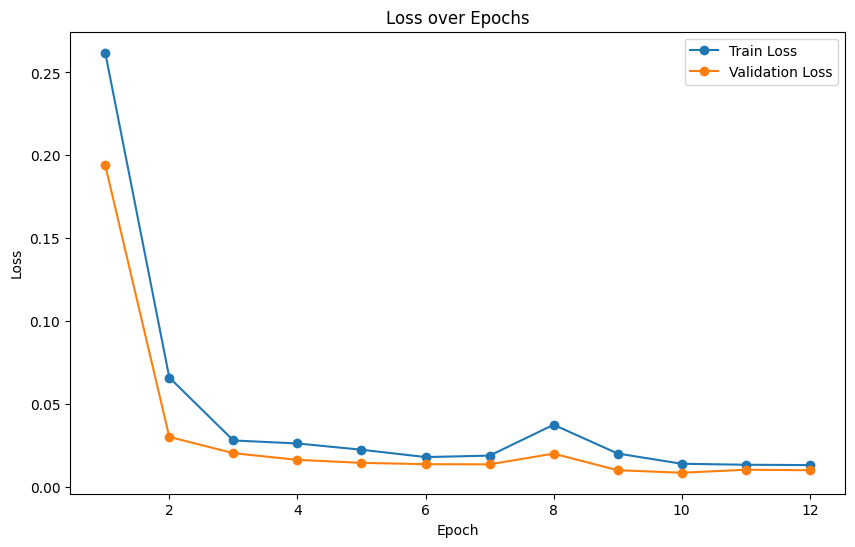

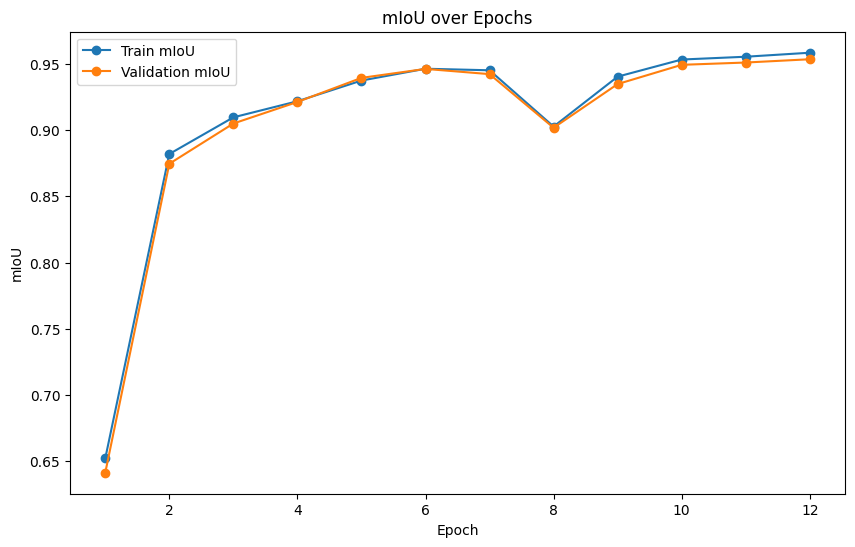

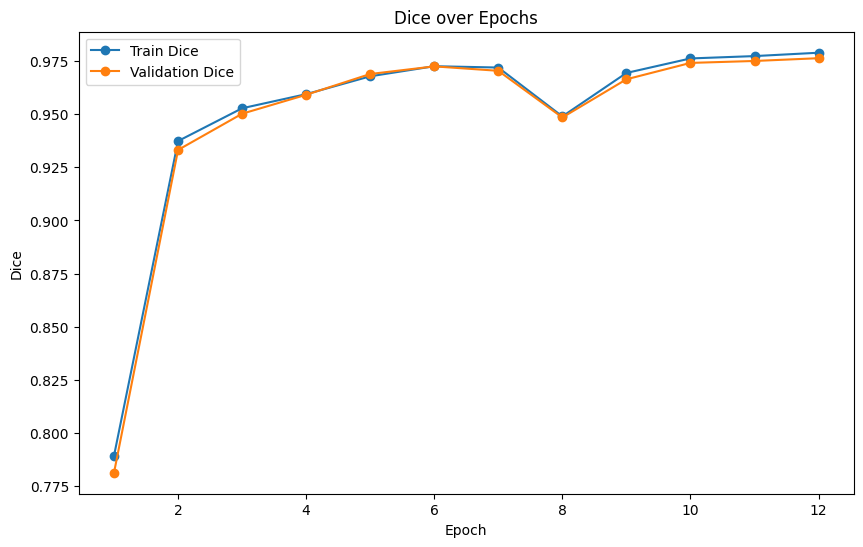

Finish


In [ ]:
def sweeper(wandb_logger, args):

    if wandb_logger:
        wandb_logger.init_run()
        args = wandb_logger._wandb.config

    seed_everything(args.seed)

    img_files = glob.glob(args.data_path)

    train_ids, valid_ids = train_test_split(range(len(img_files)), test_size=0.2, random_state=args.seed)
    train_transform, valid_transform = build_transform(True, args), build_transform(False, args)
    train_dataset = DeepMedical(images=img_files, transforms=train_transform)
    valid_dataset = DeepMedical(images=img_files, transforms=valid_transform)
    train_dataset = SonoDataset(train_dataset, train_ids)
    valid_dataset = SonoDataset(valid_dataset, valid_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1)

    model = ResUnet()
    model.to(args.device)
    if wandb_logger:
        wandb_logger._wandb.watch(model)

    params_to_optimize = [
        {"params": [p for p in model.parameters() if p.requires_grad]},
    ]

    #TO DO: try to select a proper optimizer
    optimizer = torch.optim.AdamW(
        params_to_optimize,
        lr=args.lr, weight_decay=args.weight_decay
    )
    criterion = nn.CrossEntropyLoss()

    # 以 batch 為單位來更新學習率
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = args.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = args.lr,
         anneal_strategy = 'cos'
    )

    n_parameters = sum(p.numel() for p in params_to_optimize[0]["params"])
    macs = profile_macs(model, torch.randn(args.input_size).to(args.device))

    print("Training augmentation:", train_transform)
    print('number of params (M): %.2f' % (n_parameters))
    print('model flops (G):', macs / 2 / 1.e9, 'input_size:', args.input_size)
    print("LR = %.8f" % args.lr)
    print("WD = %.8f" % args.weight_decay)
    print("Batch size = %d" % args.batch_size)
    print("Number of training epochs = %d" % args.epochs)
    print("Number of training examples = %d" % len(train_dataset))
    print("Number of training steps per epoch = %d" % (len(train_dataset) // args.batch_size))
    print("Use Cosine LR scheduler")
    print("criterion = %s" % str(criterion))

    best_dice = 0
    start_time = time.time()
    print("Start Training")

    history = {
        "train_loss": [],
        "train_miou": [],
        "train_dice": [],
        "valid_loss": [],
        "valid_miou": [],
        "valid_dice": [],
        }
    for epoch in range(args.epochs):

        train_one_epoch(model, train_loader, criterion, args.device, epoch, optimizer)
        train_logger, train_confmat = evaluate(model, train_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(train_dataset), header="Eval [Train]")
        valid_logger, valid_confmat = evaluate(model, valid_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(valid_dataset), header="Eval [Valid]")

        scheduler.step()

        history["train_loss"].append(getattr(train_logger, "loss", -1).value)
        history["train_miou"].append(getattr(train_logger, "mIoU", -1).value)
        history["train_dice"].append(getattr(train_logger, "Dice", -1).value)

        history["valid_loss"].append(getattr(valid_logger, "loss", -1).value)
        history["valid_miou"].append(getattr(valid_logger, "mIoU", -1).value)
        history["valid_dice"].append(getattr(valid_logger, "Dice", -1).value)

        if wandb_logger:
            wandb_logger._wandb.log({f"Training Loss": getattr(train_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Training mIoU": getattr(train_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Training Dice": getattr(train_logger, "Dice", -1).value})

            wandb_logger._wandb.log({f"Validation Loss": getattr(valid_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Validation mIoU": getattr(valid_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Validation Dice": getattr(valid_logger, "Dice", -1).value})

        info = str(valid_confmat)
        print(info)

        scheduler.step()

        save_file = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "epoch": epoch,
            "args": wandb_logger.config if wandb_logger else {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}
        }

        if valid_confmat.dice > best_dice:
            best_dice = valid_confmat.dice
            torch.save(save_file, os.path.join(args.output_dir, "best_ckpt.pth"))
            if wandb_logger:
                wandb_logger._wandb.save("best_ckpt.pth")
        torch.save(save_file, os.path.join(args.output_dir, "last_ckpt.pth"))
        if wandb_logger:
            wandb_logger._wandb.save("last_ckpt.pth")
            plt.figure(figsize=(12, 5))

    if wandb_logger:
        wandb_logger._wandb.log({f"Best Dice": best_dice})

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("Training finish with time {}".format(total_time_str))

    if wandb_logger:
        print("Start logging images")
        iterator = visualization(model, valid_loader, args)
        for data in iterator:
            wandb_logger.log_image(*data)
        wandb_logger._wandb.log({"Image table": wandb_logger.mask_table})
    plot_metrics(history, args.output_dir)
    print("Finish")

if __name__ == '__main__':

    #print_with_timestamp()

    args = get_args()
    config = {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}

    if args.wandb:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()

        WANDB_API = user_secrets.get_secret("wandb-api")
        wandb_logger = WandbLogger(config)
        wandb_logger.login(WANDB_API)

        if args.sweep:
            sweep_id = wandb.sweep(sweep_config, project=args.project)
            wandb.agent(sweep_id, function=lambda: sweeper(wandb_logger), count=args.sweep_counts)
        else:
            sweeper(wandb_logger, args)
    else:
        sweeper(None, args)


In [ ]:
import pandas as pd

class SonoInferenceDataset(torch.utils.data.Dataset):

    def __init__(self, root, df, transforms=None):

        self.root = root
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self,idx):

        image_path = os.path.join(self.root, "test", "pre", self.df.iloc[idx,0])

        image = np.array(Image.open(image_path).convert('RGB'))

        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image

@torch.no_grad()
def inference(model, data_loader, args):
    model.eval()

    rle = []
    for images in tqdm(data_loader):
        images = images.to(device=args.device, dtype=torch.float)

        logits = model(images)
        masks = logits.argmax(dim=1).detach().cpu().numpy()
        for batch, mask in enumerate(masks):
            mask = Image.fromarray((mask*255).astype(np.uint8)).resize((args.target_size[1], args.target_size[0]))
            rle.append(rle_encode(np.array(mask), fg_val=255))
    return rle

In [ ]:
##ResUnet
args = get_args()
sample_submission = pd.read_csv(os.path.join(args.root, "sample_submission.csv"))
test_dataset = SonoInferenceDataset(args.root, sample_submission, build_transform(False, args))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
state_dict = torch.load(os.path.join(args.output_dir, "best_ckpt.pth"), map_location=args.device)
model = ResUnet()
model.to(args.device)
model.load_state_dict(state_dict["model"])
rle = inference(model, test_loader, args)
sample_submission["rle_encode"] = [list_to_string(r) for r in rle]

from google.colab import files
# 保存 CSV 文件到指定路徑
sample_submission.to_csv('/content/ResUnet_one_12_AdamW.csv', index=False, header = True)
# 下載文件到本地機器
files.download('/content/ResUnet_one_12_AdamW.csv')

<ipython-input-27-d3ebda47f1a5>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(args.output_dir, "best_ckpt.pth"), map_location=args.de

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

num_images = 100
rows = 10
cols = 10

# 創建畫布
plt.figure(figsize=(10 * 5, 10 * 5))

for idx, x in enumerate(range(0, rows * cols)):  # 顯示 rows x cols 圖片
    rle_string = list_to_string(rle[x])  # 解碼 RLE
    decoded_image = rle_decode(rle_string)

    # 添加子圖
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(decoded_image)
    plt.title(f"Image {x + 1}")  # 圖片標題
    plt.axis("off")  # 隱藏座標軸

# 調整布局
plt.tight_layout()
plt.show()

##FCN

In [ ]:
#TO DO: try to set a more fitness parameters
def get_args():
    parser = argparse.ArgumentParser(description='SonoDataset Training')

    parser.add_argument('--root', type=str, default="/kaggle/sono")
    parser.add_argument('--device', type=str, default="cuda" if torch.cuda.is_available() else "cpu")
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('--weight_decay', type=float, default=1e-7)
    parser.add_argument('--epochs', type=int, default=40)
    parser.add_argument('--lr', type=float, default=1e-3)
    parser.add_argument('--num_classes', type=int, default=2)
    parser.add_argument('--seed', type=int, default=42)

    parser.add_argument('--in_channels', type=int, default=3)
    parser.add_argument('--input_size', type=tuple, default=(4, 3, 224, 224))
    parser.add_argument('--target_size', type=tuple, default=(566, 640))
    parser.add_argument('--mean', type=list, default=IMAGENET_DEFAULT_MEAN)
    parser.add_argument('--std', type=list, default=IMAGENET_DEFAULT_STD)

    parser.add_argument('--project', type=str, default="MIA-HW4")
    parser.add_argument('--entity', type=str, default="DDCVLAB")
    parser.add_argument('--name', type=str, default="Unet")
    parser.add_argument('--wandb', type=bool, default=False)
    parser.add_argument('--sweep', type=bool, default=True)
    parser.add_argument('--sweep_counts', type=int, default=8)

    parser.add_argument('--output_dir', type=str, default="")
    parser.add_argument('--data_path', type=str, default="/kaggle/sono/train/pre/*")

    args, _ = parser.parse_known_args()
    return args

sweep_config = {
    "program": "main.py",
    "method": "random", # ["random", "grid", "bayes"]
    "metrics": {'goal': 'maximize', 'name': 'Validation Dice'},
    "parameters": {
        "lr": {
            "values": [1e-3, 5e-4, 1e-4, 5e-5]
        },
        "weight_decay": {
            "values": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
        },
    }
}

Training augmentation: Compose([
  Resize(p=1.0, height=224, width=224, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
number of params (M): 14717590.00
model flops (G): 30.72038144 input_size: (4, 3, 224, 224)
LR = 0.00100000
WD = 0.00000010
Batch size = 4
Number of training epochs = 40
Number of training examples = 240
Number of training steps per epoch = 60
Use Cosine LR scheduler
criterion = CrossEntropyLoss()
Start Training
Epoch: [0]  [ 0/60]  eta: 0:00:07  lr: 0.000040  loss: 0.6930 (0.6930)  mIoU: 0.1118 (0.1118)  Dice: 0.2011 (0.2011)  time: 0.1295  data: 0.0154  max mem: 1192
Epoch: [0]  [10/60]  eta: 0:00:04  lr: 0.000040  loss: 0.6866 (0.6893)  mIoU: 0.1179 (0.1158)  Dice: 0.2109 (0.2076)  time: 0.0894  data: 0.0158  max me

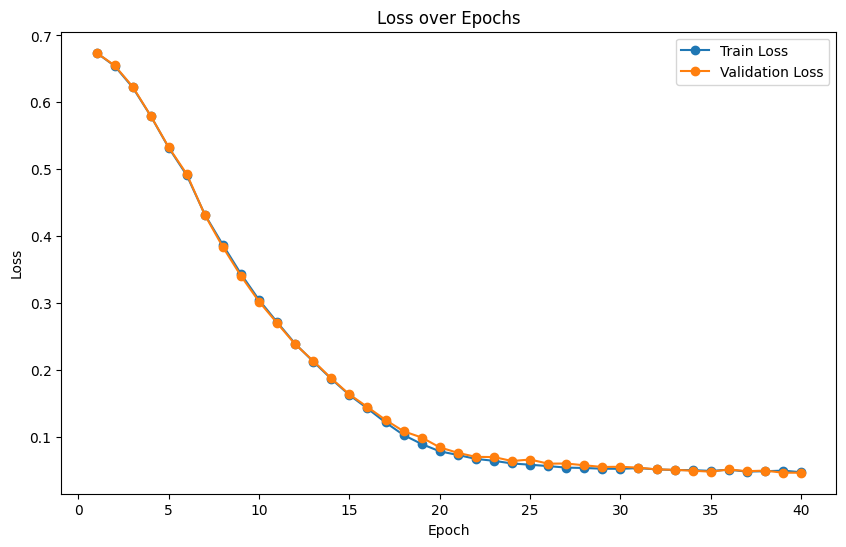

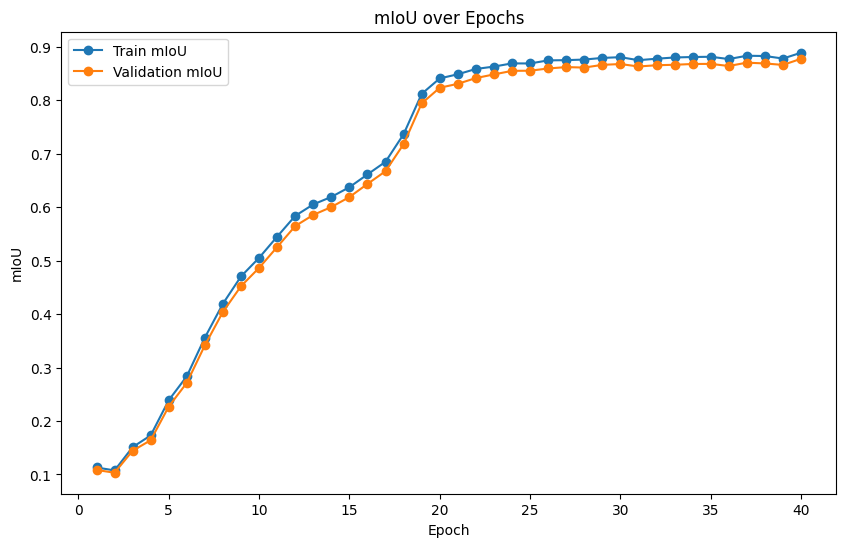

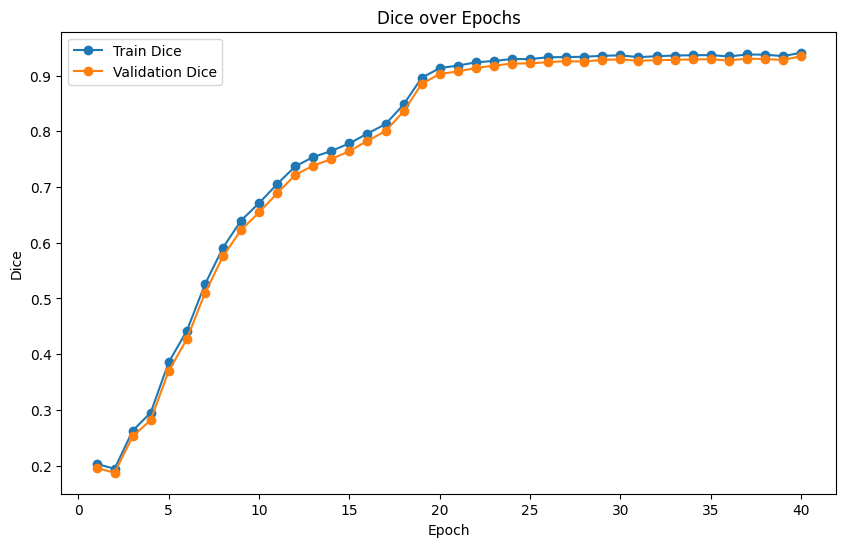

Finish


In [ ]:
def sweeper(wandb_logger, args):

    if wandb_logger:
        wandb_logger.init_run()
        args = wandb_logger._wandb.config

    seed_everything(args.seed)

    img_files = glob.glob(args.data_path)

    train_ids, valid_ids = train_test_split(range(len(img_files)), test_size=0.2, random_state=args.seed)
    train_transform, valid_transform = build_transform(True, args), build_transform(False, args)
    train_dataset = DeepMedical(images=img_files, transforms=train_transform)
    valid_dataset = DeepMedical(images=img_files, transforms=valid_transform)
    train_dataset = SonoDataset(train_dataset, train_ids)
    valid_dataset = SonoDataset(valid_dataset, valid_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1)

    model = FCN()
    model.to(args.device)
    if wandb_logger:
        wandb_logger._wandb.watch(model)

    params_to_optimize = [
        {"params": [p for p in model.parameters() if p.requires_grad]},
    ]

    #TO DO: try to select a proper optimizer
    optimizer = torch.optim.Adam(
        params_to_optimize,
        lr=args.lr, weight_decay=args.weight_decay
    )
    criterion = nn.CrossEntropyLoss()

    # 以 batch 為單位來更新學習率
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = args.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = args.lr,
         anneal_strategy = 'cos'
    )

    n_parameters = sum(p.numel() for p in params_to_optimize[0]["params"])
    macs = profile_macs(model, torch.randn(args.input_size).to(args.device))

    print("Training augmentation:", train_transform)
    print('number of params (M): %.2f' % (n_parameters))
    print('model flops (G):', macs / 2 / 1.e9, 'input_size:', args.input_size)
    print("LR = %.8f" % args.lr)
    print("WD = %.8f" % args.weight_decay)
    print("Batch size = %d" % args.batch_size)
    print("Number of training epochs = %d" % args.epochs)
    print("Number of training examples = %d" % len(train_dataset))
    print("Number of training steps per epoch = %d" % (len(train_dataset) // args.batch_size))
    print("Use Cosine LR scheduler")
    print("criterion = %s" % str(criterion))

    best_dice = 0
    start_time = time.time()
    print("Start Training")
    # 在 sweeper 函數內部添加以下變量
    history = {
        "train_loss": [],
        "train_miou": [],
        "train_dice": [],
        "valid_loss": [],
        "valid_miou": [],
        "valid_dice": [],
        }
    for epoch in range(args.epochs):

        train_one_epoch(model, train_loader, criterion, args.device, epoch, optimizer)
        train_logger, train_confmat = evaluate(model, train_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(train_dataset), header="Eval [Train]")
        valid_logger, valid_confmat = evaluate(model, valid_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(valid_dataset), header="Eval [Valid]")

        scheduler.step()

        history["train_loss"].append(getattr(train_logger, "loss", -1).value)
        history["train_miou"].append(getattr(train_logger, "mIoU", -1).value)
        history["train_dice"].append(getattr(train_logger, "Dice", -1).value)

        history["valid_loss"].append(getattr(valid_logger, "loss", -1).value)
        history["valid_miou"].append(getattr(valid_logger, "mIoU", -1).value)
        history["valid_dice"].append(getattr(valid_logger, "Dice", -1).value)


        if wandb_logger:
            wandb_logger._wandb.log({f"Training Loss": getattr(train_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Training mIoU": getattr(train_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Training Dice": getattr(train_logger, "Dice", -1).value})

            wandb_logger._wandb.log({f"Validation Loss": getattr(valid_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Validation mIoU": getattr(valid_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Validation Dice": getattr(valid_logger, "Dice", -1).value})

        info = str(valid_confmat)
        print(info)

        #scheduler.step()

        save_file = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "epoch": epoch,
            "args": wandb_logger.config if wandb_logger else {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}
        }

        if valid_confmat.dice > best_dice:
            best_dice = valid_confmat.dice
            torch.save(save_file, os.path.join(args.output_dir, "best_ckpt.pth"))
            if wandb_logger:
                wandb_logger._wandb.save("best_ckpt.pth")
        torch.save(save_file, os.path.join(args.output_dir, "last_ckpt.pth"))
        if wandb_logger:
            wandb_logger._wandb.save("last_ckpt.pth")

    if wandb_logger:
        wandb_logger._wandb.log({f"Best Dice": best_dice})

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("Training finish with time {}".format(total_time_str))

    if wandb_logger:
        print("Start logging images")
        iterator = visualization(model, valid_loader, args)
        for data in iterator:
            wandb_logger.log_image(*data)
        wandb_logger._wandb.log({"Image table": wandb_logger.mask_table})

    plot_metrics(history, args.output_dir)

    print("Finish")

if __name__ == '__main__':

    #print_with_timestamp()

    args = get_args()
    config = {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}

    if args.wandb:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()

        WANDB_API = user_secrets.get_secret("wandb-api")
        wandb_logger = WandbLogger(config)
        wandb_logger.login(WANDB_API)

        if args.sweep:
            sweep_id = wandb.sweep(sweep_config, project=args.project)
            wandb.agent(sweep_id, function=lambda: sweeper(wandb_logger), count=args.sweep_counts)
        else:
            sweeper(wandb_logger, args)
    else:
        sweeper(None, args)

In [ ]:
import pandas as pd

class SonoInferenceDataset(torch.utils.data.Dataset):

    def __init__(self, root, df, transforms=None):

        self.root = root
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self,idx):

        image_path = os.path.join(self.root, "test", "pre", self.df.iloc[idx,0])

        image = np.array(Image.open(image_path).convert('RGB'))

        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image

@torch.no_grad()
def inference(model, data_loader, args):
    model.eval()

    rle = []
    for images in tqdm(data_loader):
        images = images.to(device=args.device, dtype=torch.float)

        logits = model(images)
        masks = logits.argmax(dim=1).detach().cpu().numpy()
        for batch, mask in enumerate(masks):
            mask = Image.fromarray((mask*255).astype(np.uint8)).resize((args.target_size[1], args.target_size[0]))
            rle.append(rle_encode(np.array(mask), fg_val=255))
    return rle

In [ ]:
###FCN
args = get_args()
sample_submission = pd.read_csv(os.path.join(args.root, "sample_submission.csv"))
test_dataset = SonoInferenceDataset(args.root, sample_submission, build_transform(False, args))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
state_dict = torch.load(os.path.join(args.output_dir, "best_ckpt.pth"), map_location=args.device)
model = FCN()
model.to(args.device)
model.load_state_dict(state_dict["model"])
rle = inference(model, test_loader, args)
sample_submission["rle_encode"] = [list_to_string(r) for r in rle]
#sample_submission.to_csv("submission.csv", index=0)

from google.colab import files
# 保存 CSV 文件到指定路徑
sample_submission.to_csv('/content/FCN_one_40.csv', index=False, header = True)
# 下載文件到本地機器
files.download('/content/FCN_one_40.csv')

<ipython-input-22-4f4bec0a652e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(args.output_dir, "best_ckpt.pth"), map_location=args.de

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

num_images = 100
rows = 10
cols = 10

# 創建畫布
plt.figure(figsize=(10 * 5, 10 * 5))

for idx, x in enumerate(range(0, rows * cols)):  # 顯示 rows x cols 圖片
    rle_string = list_to_string(rle[x])  # 解碼 RLE
    decoded_image = rle_decode(rle_string)

    # 添加子圖
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(decoded_image)
    plt.title(f"Image {x + 1}")  # 圖片標題
    plt.axis("off")  # 隱藏座標軸

# 調整布局
plt.tight_layout()
plt.show()


##Unet

In [ ]:
###修改的transformation：有augmentation but no horizontal flip
def build_transform(is_train, args):
    """
    Create a data transformation pipeline for blood vessel analysis.
    """
    t = []
    if is_train:
        # Resize to target size
        t.append(A.Resize(args.input_size[-2], args.input_size[-1]))
        # Brightness, contrast, and noise
        t.append(A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5))
        t.append(A.GaussNoise(var_limit=(10.0, 50.0), p=0.5))
        # CLAHE for medical image contrast enhancement
        t.append(A.CLAHE(clip_limit=4.0, p=0.5))
        # Convert to tensor
        t.append(A.Normalize(args.mean, args.std))
        t.append(ToTensorV2())
        return A.Compose(t)

    # Testing phase
    t.append(A.Resize(args.input_size[-2], args.input_size[-1]))
    t.append(A.Normalize(args.mean, args.std))
    t.append(ToTensorV2())
    return A.Compose(t)

In [ ]:
class config:

    input_size = (8, 3, 448, 448)
    mean = IMAGENET_DEFAULT_MEAN
    std = IMAGENET_DEFAULT_STD

img_files = glob.glob("/kaggle/sono/train/pre/*")
ds = DeepMedical(images=img_files, transforms=build_transform(True, config))
dl = torch.utils.data.DataLoader(ds,batch_size=16,shuffle=False,num_workers=0)

plt.figure(figsize=(16,16))
imgs,masks = next(iter(dl))

for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*torch.tensor(config.std) + torch.tensor(config.mean))*255.0).numpy().astype(np.uint8)

    plt.subplot(4,4,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)

print(f"Image shape: {imgs.shape}, mask shape {mask.shape}")

del ds,dl,imgs,masks

In [ ]:
#TO DO: try to set a more fitness parameters
def get_args():
    parser = argparse.ArgumentParser(description='SonoDataset Training')

    parser.add_argument('--root', type=str, default="/kaggle/sono")
    parser.add_argument('--device', type=str, default="cuda" if torch.cuda.is_available() else "cpu")
    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('--weight_decay', type=float, default=1e-7)
    parser.add_argument('--epochs', type=int, default=40)
    parser.add_argument('--lr', type=float, default=1e-3)
    parser.add_argument('--num_classes', type=int, default=2)
    parser.add_argument('--seed', type=int, default=42)

    parser.add_argument('--in_channels', type=int, default=3)
    parser.add_argument('--input_size', type=tuple, default=(4, 3, 224, 224))
    parser.add_argument('--target_size', type=tuple, default=(566, 640))
    parser.add_argument('--mean', type=list, default=IMAGENET_DEFAULT_MEAN)
    parser.add_argument('--std', type=list, default=IMAGENET_DEFAULT_STD)

    parser.add_argument('--project', type=str, default="MIA-HW4")
    parser.add_argument('--entity', type=str, default="DDCVLAB")
    parser.add_argument('--name', type=str, default="Unet")
    parser.add_argument('--wandb', type=bool, default=False)
    parser.add_argument('--sweep', type=bool, default=True)
    parser.add_argument('--sweep_counts', type=int, default=8)

    parser.add_argument('--output_dir', type=str, default="")
    parser.add_argument('--data_path', type=str, default="/kaggle/sono/train/pre/*")

    args, _ = parser.parse_known_args()
    return args

sweep_config = {
    "program": "main.py",
    "method": "random", # ["random", "grid", "bayes"]
    "metrics": {'goal': 'maximize', 'name': 'Validation Dice'},
    "parameters": {
        "lr": {
            "values": [1e-3, 5e-4, 1e-4, 5e-5]
        },
        "weight_decay": {
            "values": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
        },
    }
}

Training augmentation: Compose([
  Resize(p=1.0, height=224, width=224, interpolation=1, mask_interpolation=0),
  RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True),
  GaussNoise(p=0.5, var_limit=(10.0, 50.0), per_channel=True, mean=0.0, noise_scale_factor=1.0),
  CLAHE(p=0.5, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8)),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
number of params (M): 31030850.00
model flops (G): 83.627737088 input_size: (4, 3, 224, 224)
LR = 0.00100000
WD = 0.00000010
Batch size = 4
Number of training epochs = 40
Number of training examples = 240
Number of training steps per epoch = 60
Use Cosine LR scheduler
criterion = CrossEntropyLoss()
Start Training
Epoch: [0]  [ 0/60]  eta: 0:00:13  

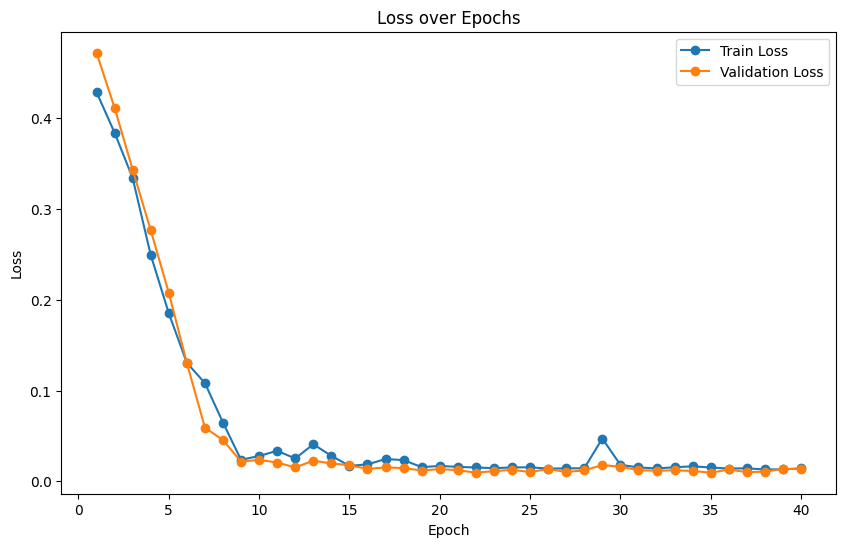

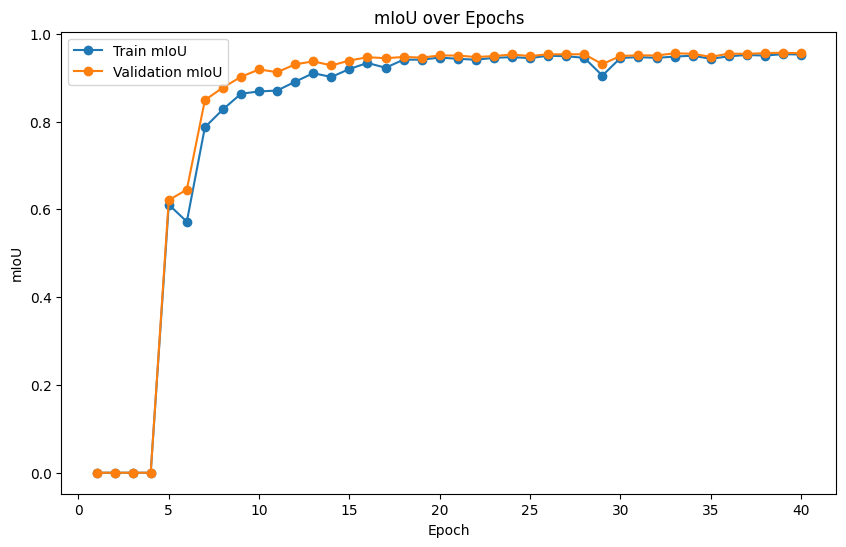

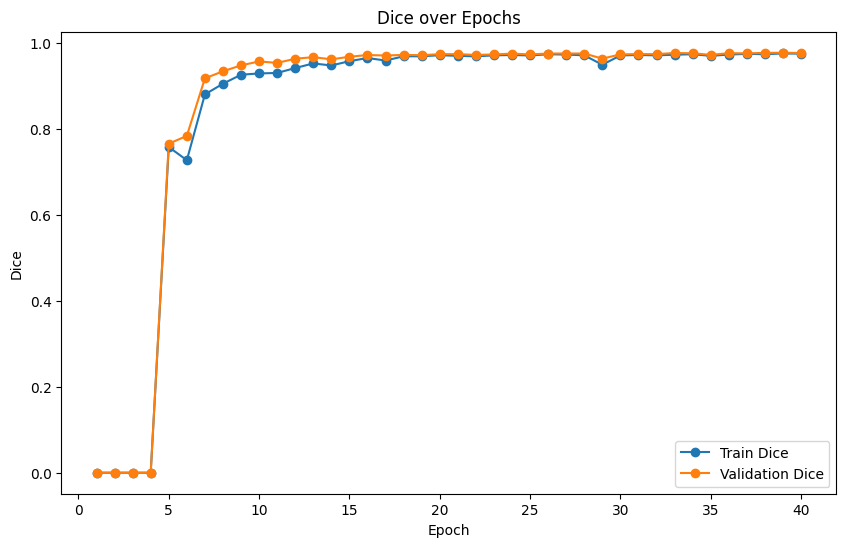

Finish


In [ ]:
###epoch=40/AdamW/OnecycleLR
def sweeper(wandb_logger, args):

    if wandb_logger:
        wandb_logger.init_run()
        args = wandb_logger._wandb.config

    seed_everything(args.seed)

    img_files = glob.glob(args.data_path)

    train_ids, valid_ids = train_test_split(range(len(img_files)), test_size=0.2, random_state=args.seed)
    train_transform, valid_transform = build_transform(True, args), build_transform(False, args)
    train_dataset = DeepMedical(images=img_files, transforms=train_transform)
    valid_dataset = DeepMedical(images=img_files, transforms=valid_transform)
    train_dataset = SonoDataset(train_dataset, train_ids)
    valid_dataset = SonoDataset(valid_dataset, valid_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1)

    model = Unet()
    model.to(args.device)
    if wandb_logger:
        wandb_logger._wandb.watch(model)

    params_to_optimize = [
        {"params": [p for p in model.parameters() if p.requires_grad]},
    ]

    #TO DO: try to select a proper optimizer
    optimizer = torch.optim.AdamW(
        params_to_optimize,
        lr=args.lr, weight_decay=args.weight_decay
    )
    criterion = nn.CrossEntropyLoss()
    #criterion = nn.BCELoss()
    #criterion = nn.MSELoss()
    # 以 batch 為單位來更新學習率
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = args.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = args.lr,
         anneal_strategy = 'cos'
    )

    n_parameters = sum(p.numel() for p in params_to_optimize[0]["params"])
    macs = profile_macs(model, torch.randn(args.input_size).to(args.device))

    print("Training augmentation:", train_transform)
    print('number of params (M): %.2f' % (n_parameters))
    print('model flops (G):', macs / 2 / 1.e9, 'input_size:', args.input_size)
    print("LR = %.8f" % args.lr)
    print("WD = %.8f" % args.weight_decay)
    print("Batch size = %d" % args.batch_size)
    print("Number of training epochs = %d" % args.epochs)
    print("Number of training examples = %d" % len(train_dataset))
    print("Number of training steps per epoch = %d" % (len(train_dataset) // args.batch_size))
    print("Use Cosine LR scheduler")
    print("criterion = %s" % str(criterion))

    best_dice = 0
    start_time = time.time()
    print("Start Training")
    # 在 sweeper 函數內部添加以下變量
    history = {
        "train_loss": [],
        "train_miou": [],
        "train_dice": [],
        "valid_loss": [],
        "valid_miou": [],
        "valid_dice": [],
        }
    for epoch in range(args.epochs):

        train_one_epoch(model, train_loader, criterion, args.device, epoch, optimizer)
        train_logger, train_confmat = evaluate(model, train_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(train_dataset), header="Eval [Train]")
        valid_logger, valid_confmat = evaluate(model, valid_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(valid_dataset), header="Eval [Valid]")

        scheduler.step()

        history["train_loss"].append(getattr(train_logger, "loss", -1).value)
        history["train_miou"].append(getattr(train_logger, "mIoU", -1).value)
        history["train_dice"].append(getattr(train_logger, "Dice", -1).value)

        history["valid_loss"].append(getattr(valid_logger, "loss", -1).value)
        history["valid_miou"].append(getattr(valid_logger, "mIoU", -1).value)
        history["valid_dice"].append(getattr(valid_logger, "Dice", -1).value)

        if wandb_logger:
            wandb_logger._wandb.log({f"Training Loss": getattr(train_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Training mIoU": getattr(train_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Training Dice": getattr(train_logger, "Dice", -1).value})

            wandb_logger._wandb.log({f"Validation Loss": getattr(valid_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Validation mIoU": getattr(valid_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Validation Dice": getattr(valid_logger, "Dice", -1).value})

        info = str(valid_confmat)
        print(info)

        #scheduler.step()

        save_file = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
            "epoch": epoch,
            "args": wandb_logger.config if wandb_logger else {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}
        }

        if valid_confmat.dice > best_dice:
            best_dice = valid_confmat.dice
            torch.save(save_file, os.path.join(args.output_dir, "best_ckpt.pth"))
            if wandb_logger:
                wandb_logger._wandb.save("best_ckpt.pth")
        torch.save(save_file, os.path.join(args.output_dir, "last_ckpt.pth"))
        if wandb_logger:
            wandb_logger._wandb.save("last_ckpt.pth")

    if wandb_logger:
        wandb_logger._wandb.log({f"Best Dice": best_dice})

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("Training finish with time {}".format(total_time_str))

    if wandb_logger:
        print("Start logging images")
        iterator = visualization(model, valid_loader, args)
        for data in iterator:
            wandb_logger.log_image(*data)
        wandb_logger._wandb.log({"Image table": wandb_logger.mask_table})

    plot_metrics(history, args.output_dir)

    print("Finish")

if __name__ == '__main__':

    #print_with_timestamp()

    args = get_args()
    config = {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}

    if args.wandb:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()

        WANDB_API = user_secrets.get_secret("wandb-api")
        wandb_logger = WandbLogger(config)
        wandb_logger.login(WANDB_API)

        if args.sweep:
            sweep_id = wandb.sweep(sweep_config, project=args.project)
            wandb.agent(sweep_id, function=lambda: sweeper(wandb_logger), count=args.sweep_counts)
        else:
            sweeper(wandb_logger, args)
    else:
        sweeper(None, args)

In [ ]:
import pandas as pd

class SonoInferenceDataset(torch.utils.data.Dataset):

    def __init__(self, root, df, transforms=None):

        self.root = root
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self,idx):

        image_path = os.path.join(self.root, "test", "pre", self.df.iloc[idx,0])

        image = np.array(Image.open(image_path).convert('RGB'))

        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']

        return image

@torch.no_grad()
def inference(model, data_loader, args):
    model.eval()

    rle = []
    for images in tqdm(data_loader):
        images = images.to(device=args.device, dtype=torch.float)

        logits = model(images)
        masks = logits.argmax(dim=1).detach().cpu().numpy()
        for batch, mask in enumerate(masks):
            mask = Image.fromarray((mask*255).astype(np.uint8)).resize((args.target_size[1], args.target_size[0]))
            rle.append(rle_encode(np.array(mask), fg_val=255))
    return rle

In [ ]:
###Unet
args = get_args()
sample_submission = pd.read_csv(os.path.join(args.root, "sample_submission.csv"))
test_dataset = SonoInferenceDataset(args.root, sample_submission, build_transform(False, args))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
state_dict = torch.load(os.path.join(args.output_dir, "best_ckpt.pth"), map_location=args.device)
model = Unet()
model.to(args.device)
model.load_state_dict(state_dict["model"])
rle = inference(model, test_loader, args)
sample_submission["rle_encode"] = [list_to_string(r) for r in rle]

from google.colab import files
# 保存 CSV 文件到指定路徑
sample_submission.to_csv('/content/Unet_one_40_AdamW_noflip.csv', index=False, header = True)
# 下載文件到本地機器
files.download('/content/Unet_one_40_AdamW_noflip.csv')

<ipython-input-31-b16fd3337daf>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(args.output_dir, "best_ckpt.pth"), map_location=args.de

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import matplotlib.pyplot as plt

num_images = 100
rows = 10
cols = 10

# 創建畫布
plt.figure(figsize=(10 * 5, 10 * 5))

for idx, x in enumerate(range(0, rows * cols)):  # 顯示 rows x cols 圖片
    rle_string = list_to_string(rle[x])  # 解碼 RLE
    decoded_image = rle_decode(rle_string)

    # 添加子圖
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(decoded_image)
    plt.title(f"Image {x + 1}")  # 圖片標題
    plt.axis("off")  # 隱藏座標軸

# 調整布局
plt.tight_layout()
plt.show()
